In [59]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import imageio

plt.rc('text', usetex = True) # Use LaTeX font in plots
plt.rcParams['text.latex.preamble'] = [r'\usepackage{gensymb}']
#                                       r'\usepackage{sansmath}',
#                                       r'\sansmath']

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  


# General process
1. Process your data
- Identify known lines in your spectrum
- Create line list
- Fit polynomial to line list (+ examine residuals)
- Apply wavelength solution to data!

### Mercury wavelength calibration

In [2]:
hg_im = imageio.imread('hg_lamp_1-sixteenth_s_2.bmp')
hg_hdu = fits.PrimaryHDU(hg_im)
hg_hdu.writeto('Hg.fits', overwrite=True)
hg_spec = fits.getdata('Hg.fits')

In [3]:
# Access the section of the image that has the spectrum on it
hg_rect = hg_spec[395:540,:] # This is a little liberal, but the lines aren't vertically aligned with each other

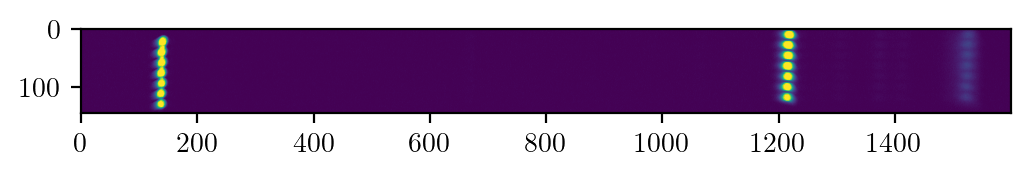

In [4]:
# Plot the spectrum
plt.figure(dpi = 100)
plt.rc('font', family='serif')
plt.imshow(hg_rect)

In [5]:
hg_collapsed = np.median(hg_rect, axis=0) # Collapse along the vertical (slit) axis
hg_detector_loc = np.arange(len(hg_collapsed)) # Create an array of pixel indices

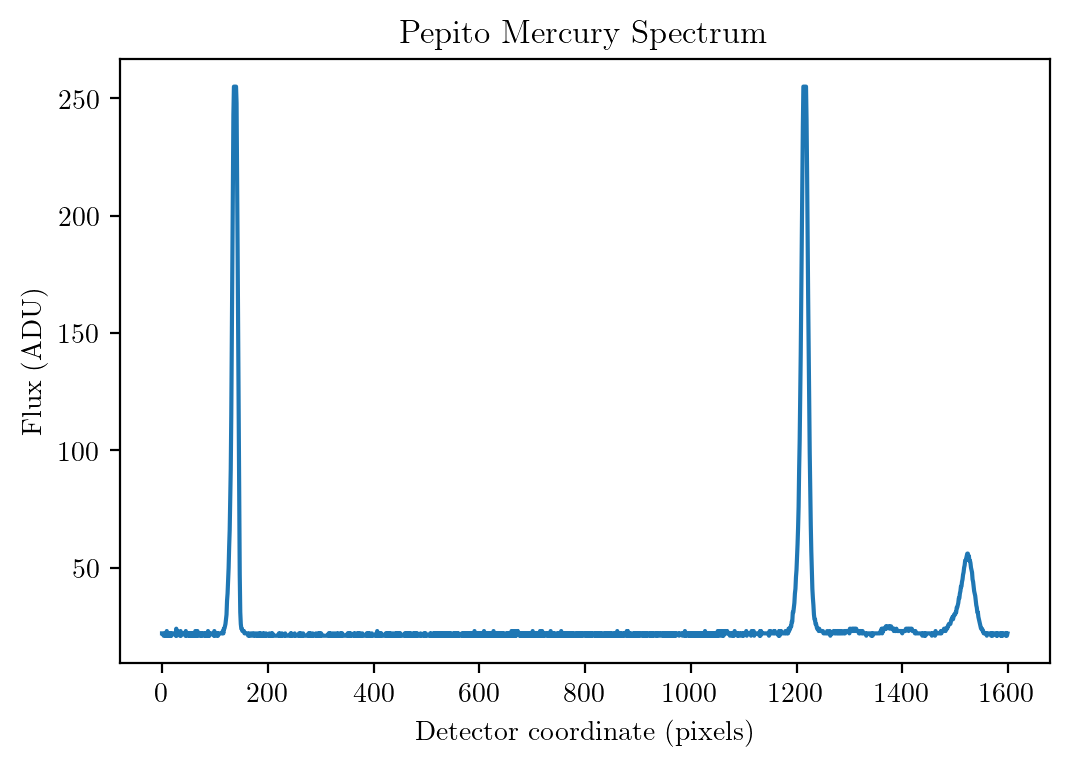

In [6]:
# Plot the spectrum against detector position
plt.figure(dpi = 100)
plt.rc('font', family='serif')
plt.plot(hg_detector_loc, hg_collapsed)
# plt.xlim([0, 1200]) # 1530 original lower bound
# plt.ylim([0, 5000])
plt.xlabel(r'Detector coordinate (pixels)')
plt.ylabel(r'Flux (ADU)')
plt.title(r'Pepito Mercury Spectrum')
plt.show()

In [7]:
def get_line_centroid(x_bounds, detector_px, flux):
    indcs = (detector_px > x_bounds[0]) & (detector_px < x_bounds[1])  # get the indices where we're in between the specified bounds
    x_i, m_i = detector_px[indcs], flux[indcs]  # apply the indices to our detector location and flux arrays
    return sum(x_i * m_i) / sum(m_i)  # return the centroid (flux weighted center-of-mass of the line)

In [8]:
# Get centroid of line, using the plot above to guess bounds (NOT spectrum in DS9, that's harder)
print(f'{get_line_centroid([1360, 1380], hg_detector_loc, hg_collapsed):.2f}')

1370.13


In [9]:
# Generate a CSV file that includes the detector location of the line as well as the wavelength you believe it is
# Use the centroiding function in the above cell instead of eye-ball estimates
# Get wavelength location of lines from: https://physics.nist.gov/PhysRefData/Handbook/Tables/mercurytable3.htm
# REMEMBER: 0 to 1600 pixels goes from red to blue
"""
Sarik's file, for the data we took in class (not the data Alyssa is working with):
pepito_lines.csv:
lamp,wl_AA,loc_px
Hg,4046.563,905.1
Hg,4078,891.5
Hg,4358,754.5
Hg,5461,226.5
Hg,5770,77.6
Hg,5790,67.5
"""
# hg_line_data = np.genfromtxt('pepito_lines.csv', names=True, delimiter=',', dtype=float) # Try Sarik's file
hg_line_data = np.genfromtxt('pepito_mercury_lines.csv', names=True, delimiter=',', dtype=float)  # Load our file
hg_wavelengths, hg_locations = hg_line_data['wl_AA'], hg_line_data['loc_px']
hg_argsort = np.argsort(hg_locations)  # Sort the wavelengths by their detector locations to prevent issues later on
hg_locations, hg_wavelengths = hg_locations[hg_argsort], hg_wavelengths[hg_argsort]  # Apply the sorted indices to the original arrays

In [10]:
print(hg_locations)
print(hg_wavelengths)

[ 136.85 1215.22 1520.87]
[5460.735 4358.328 4046.563]


In [11]:
hg_coeffs = np.polyfit(hg_locations, hg_wavelengths, deg=3)  # determine coefficients for a polynomial of degree 5 to be fit to the data
print(hg_coeffs)  # A*x^5 + B*x^4 + C*x^3 + D*x^2 + E*x + F; very small valued coefficients indicate you're probably over-fitting
hg_polynomial = np.poly1d(hg_coeffs)  # create a poly1d object from our coefficients for np.polyval to use
hg_fitted_wavelengths = np.polyval(hg_polynomial, hg_locations)  # get the wavelength from the fit for the specified detector coordinates

[ 1.33913596e-07 -3.83075764e-04 -7.26881206e-01  5.56703970e+03]


/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3418: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


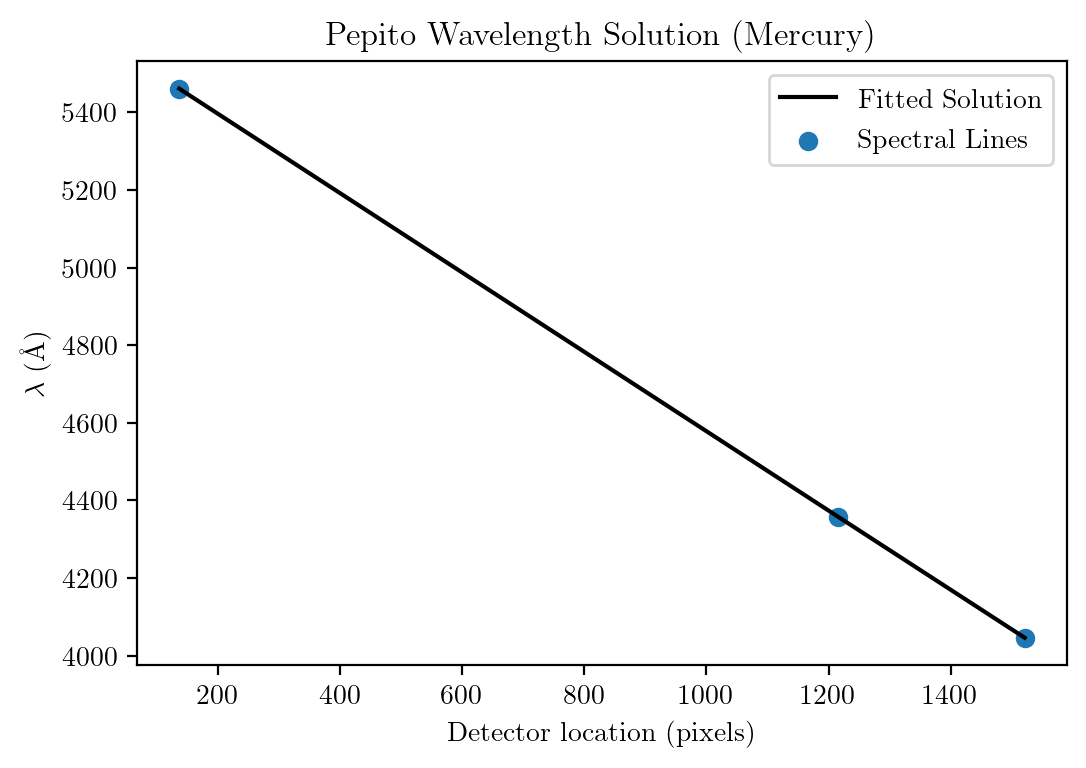

In [12]:
# Plot the fit
plt.figure(dpi = 100)
plt.rc('font', family='serif')
plt.scatter(hg_locations, hg_wavelengths, label='Spectral Lines')
plt.plot(hg_locations, hg_fitted_wavelengths, c='k', label='Fitted Solution')
plt.xlabel('Detector location (pixels)')
plt.ylabel(r'$\lambda$ (\AA)')
plt.title('Pepito Wavelength Solution (Mercury)')
plt.legend()
plt.show()

In [13]:
hg_residuals = hg_fitted_wavelengths - hg_wavelengths
print(np.std(hg_residuals))

1.5458437439498038e-12


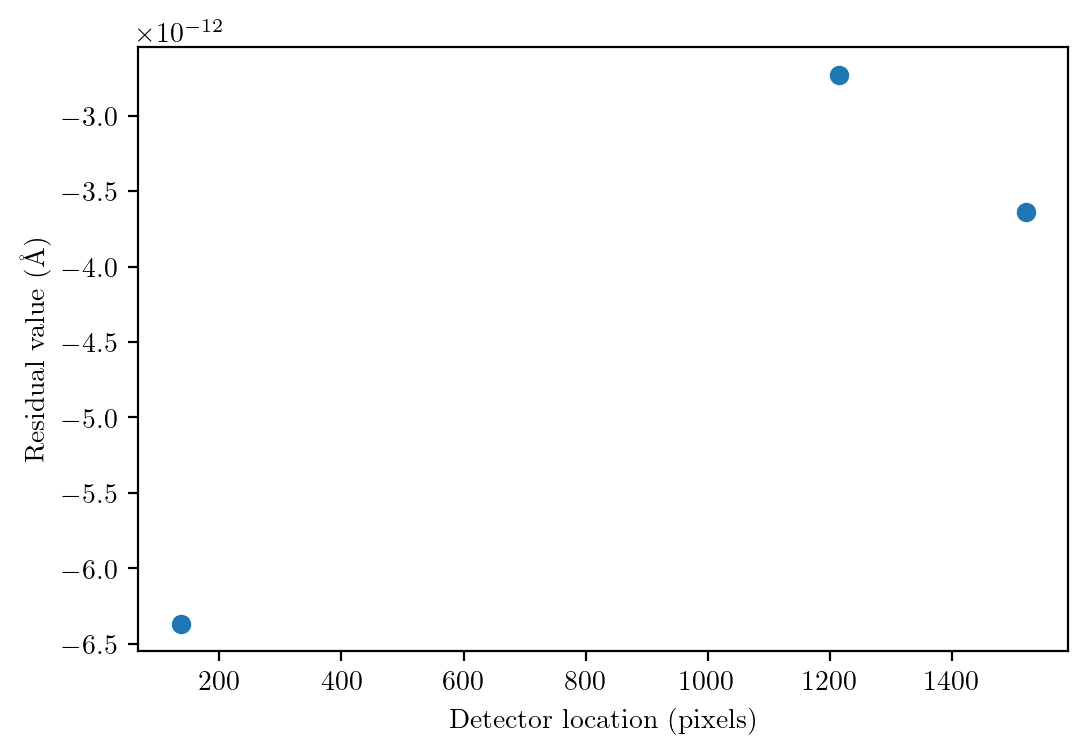

In [14]:
# Plot the residuals
plt.figure(dpi = 100)
plt.rc('font', family='serif')
plt.scatter(hg_locations, hg_residuals)
plt.xlabel('Detector location (pixels)')
plt.ylabel(r'Residual value (\AA)')
plt.show()

### Krypton wavelength calibration

In [15]:
kr_im = imageio.imread('kr_lamp_p6_2.bmp')
kr_hdu = fits.PrimaryHDU(kr_im)
kr_hdu.writeto('Kr.fits', overwrite=True)
kr_spec = fits.getdata('Kr.fits')

In [16]:
# Access the section of the image that has the spectrum on it
kr_rect = kr_spec[397:538,:] # This is a little liberal, but the lines aren't vertically aligned with each other

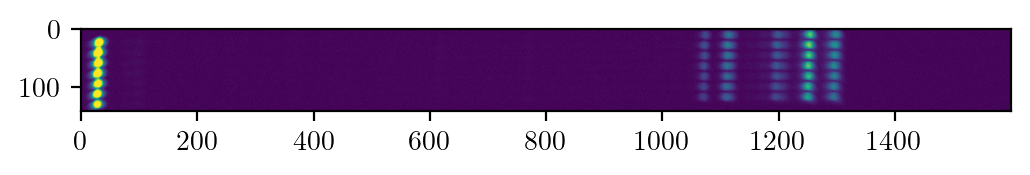

In [17]:
# Plot the spectrum
plt.figure(dpi = 100)
plt.rc('font', family='serif')
plt.imshow(kr_rect)

In [18]:
kr_collapsed = np.median(kr_rect, axis=0) # Collapse along the vertical (slit) axis
kr_detector_loc = np.arange(len(kr_collapsed)) # Create an array of pixel indices

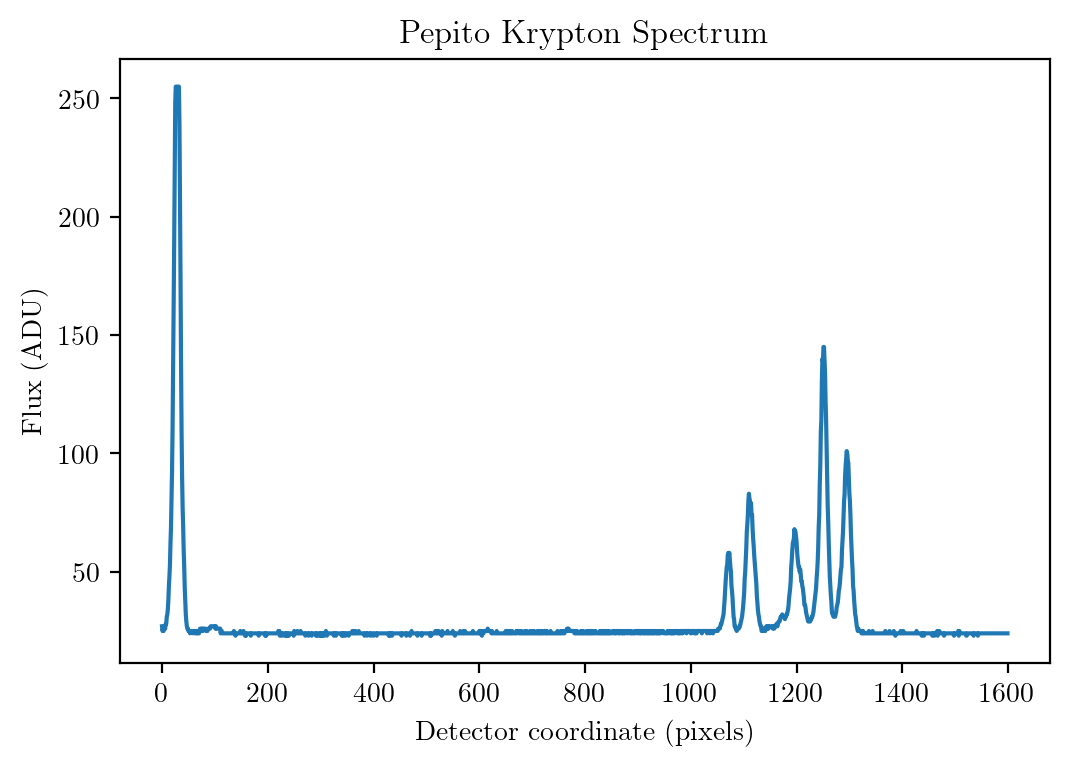

In [19]:
# Plot the spectrum against detector position
plt.figure(dpi = 100)
plt.rc('font', family='serif')
plt.plot(kr_detector_loc, kr_collapsed)
# plt.xlim([0, 1200]) # 1530 original lower bound
# plt.ylim([0, 5000])
plt.xlabel('Detector coordinate (pixels)')
plt.ylabel('Flux (ADU)')
plt.title('Pepito Krypton Spectrum')
plt.show()

In [20]:
# Get centroid of line, using the plot above to guess bounds (NOT spectrum in DS9, that's harder)
print(f'{get_line_centroid([1280, 1310], kr_detector_loc, kr_collapsed):.2f}')

1295.03


In [21]:
# Estimate wavelength of observed emission line in neon spectrum using our wavelength solution for mercury
print(np.polyval(hg_polynomial, 1295.03)) 

4274.096042173154


In [22]:
# Generate a CSV file that includes the detector location of the line as well as the wavelength you believe it is
# Use the centroiding function in the above cell instead of eye-ball estimates
# Get wavelength location of lines from: https://physics.nist.gov/PhysRefData/Handbook/Tables/mercurytable3.htm
# REMEMBER: 0 to 1600 pixels goes from red to blue
kr_line_data = np.genfromtxt('pepito_krypton_lines.csv', names=True, delimiter=',', dtype=float)  # Load our file
kr_wavelengths, kr_locations = kr_line_data['wl_AA'], kr_line_data['loc_px']
kr_argsort = np.argsort(kr_locations)  # Sort the wavelengths by their detector locations to prevent issues later on
kr_locations, kr_wavelengths = kr_locations[kr_argsort], kr_wavelengths[kr_argsort]  # Apply the sorted indices to the original arrays

In [23]:
print(kr_locations)
print(kr_wavelengths)

[  27.46 1250.49 1295.03]
[5570.2894 4319.5794 4273.9694]


In [24]:
kr_coeffs = np.polyfit(kr_locations, kr_wavelengths, deg=3)  # determine coefficients for a polynomial of degree 5 to be fit to the data
print(kr_coeffs)  # A*x^5 + B*x^4 + C*x^3 + D*x^2 + E*x + F; very small valued coefficients indicate you're probably over-fitting
kr_polynomial = np.poly1d(kr_coeffs)  # create a poly1d object from our coefficients for np.polyval to use
kr_fitted_wavelengths = np.polyval(kr_polynomial, kr_locations)  # get the wavelength from the fit for the specified detector coordinates

[ 1.20220670e-07 -3.10422784e-04 -8.18138460e-01  5.59298707e+03]


/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3418: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


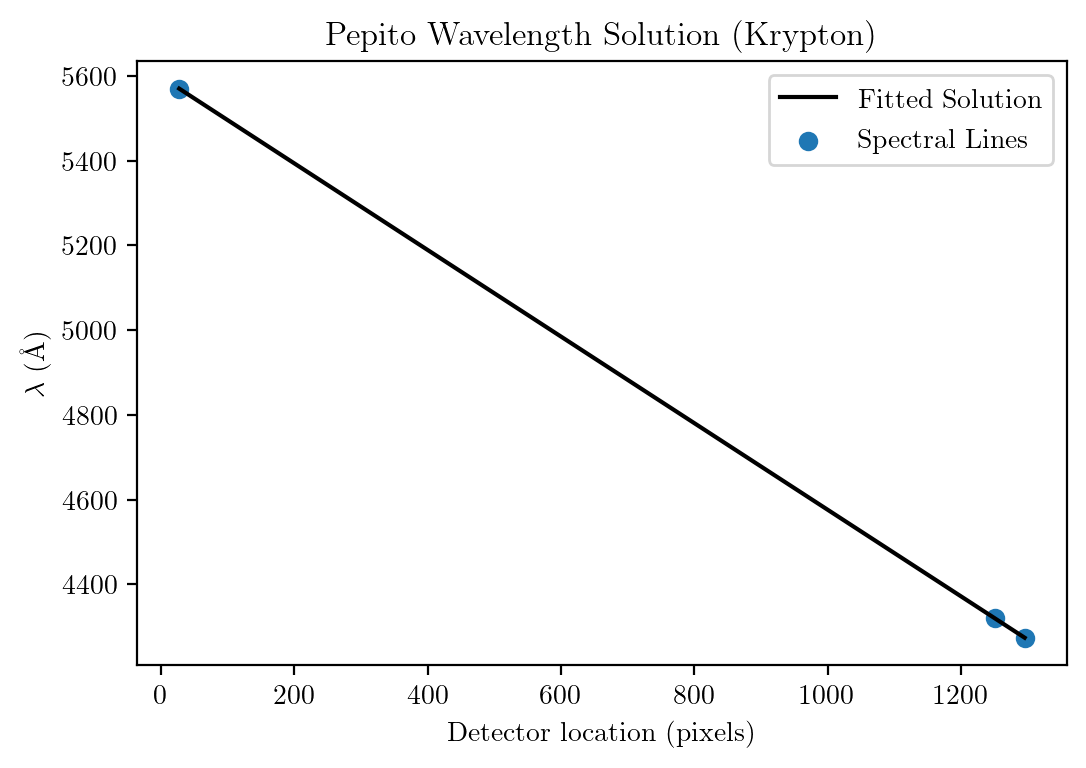

In [25]:
# Plot the fit
plt.figure(dpi = 100)
plt.rc('font', family='serif')
plt.scatter(kr_locations, kr_wavelengths, label='Spectral Lines')
plt.plot(kr_locations, kr_fitted_wavelengths, c='k', label='Fitted Solution')
plt.xlabel('Detector location (pixels)')
plt.ylabel(r'$\lambda$ (\AA)')
plt.title('Pepito Wavelength Solution (Krypton)')
plt.legend()
plt.show()

In [26]:
kr_residuals = kr_fitted_wavelengths - kr_wavelengths
print(np.std(kr_residuals))

1.1343391897068132e-12


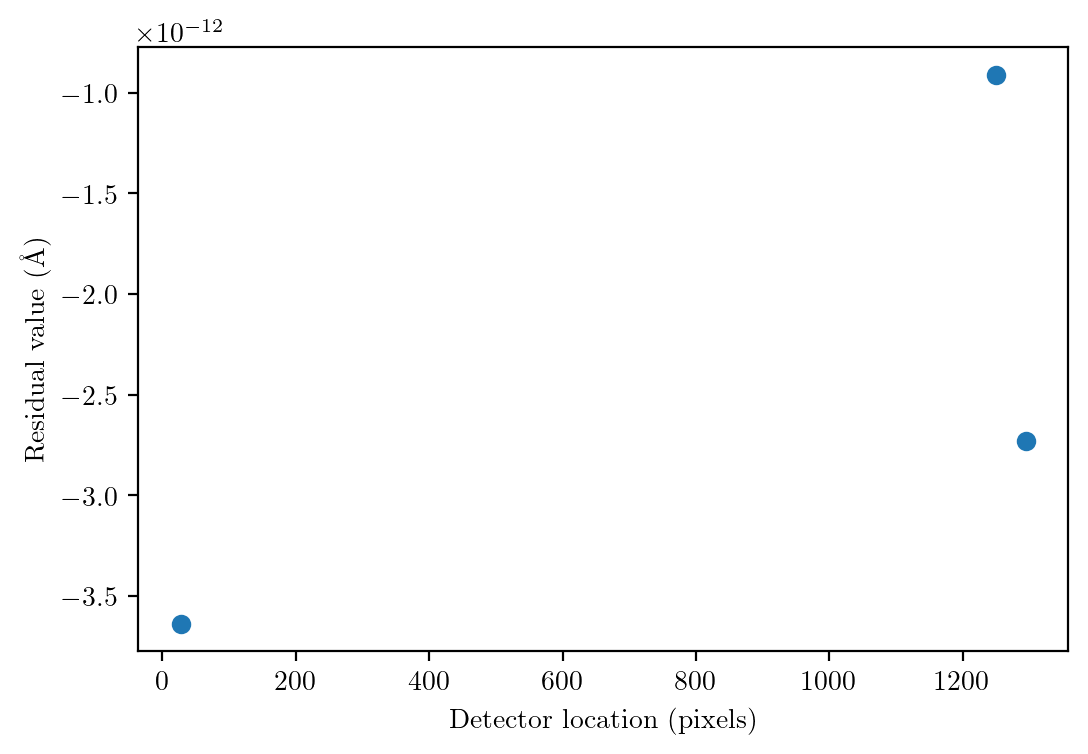

In [27]:
# Plot the residuals
plt.figure(dpi = 100)
plt.rc('font', family='serif')
plt.scatter(kr_locations, kr_residuals)
plt.xlabel('Detector location (pixels)')
plt.ylabel(r'Residual value (\AA)')
plt.show()

### Mercury and krypton wavelength calibration

In [28]:
hg_kr_line_data = np.genfromtxt('pepito_mercury_krypton_lines.csv', names=True, delimiter=',', dtype=float)  # Load our file
hg_kr_wavelengths, hg_kr_locations = hg_kr_line_data['wl_AA'], hg_kr_line_data['loc_px']
hg_kr_argsort = np.argsort(hg_kr_locations)  # Sort the wavelengths by their detector locations to prevent issues later on
hg_kr_locations, hg_kr_wavelengths = hg_kr_locations[hg_kr_argsort], hg_kr_wavelengths[hg_kr_argsort]  # Apply the sorted indices to the original arrays

In [29]:
print(hg_kr_locations)
print(hg_kr_wavelengths)

[  27.46  136.85 1215.22 1250.49 1295.03 1520.87]
[5570.2894 5460.735  4358.328  4319.5794 4273.9694 4046.563 ]


In [30]:
hg_kr_coeffs = np.polyfit(hg_kr_locations, hg_kr_wavelengths, deg=5)  # determine coefficients for a polynomial of degree 5 to be fit to the data
print(hg_kr_coeffs)  # A*x^5 + B*x^4 + C*x^3 + D*x^2 + E*x + F; very small valued coefficients indicate you're probably over-fitting
hg_kr_polynomial = np.poly1d(hg_kr_coeffs)  # create a poly1d object from our coefficients for np.polyval to use
hg_kr_fitted_wavelengths = np.polyval(hg_kr_polynomial, hg_kr_locations)  # get the wavelength from the fit for the specified detector coordinates

[-2.27842333e-12  9.65928068e-09 -1.40799562e-05  7.70193047e-03
 -1.96971141e+00  5.61885611e+03]


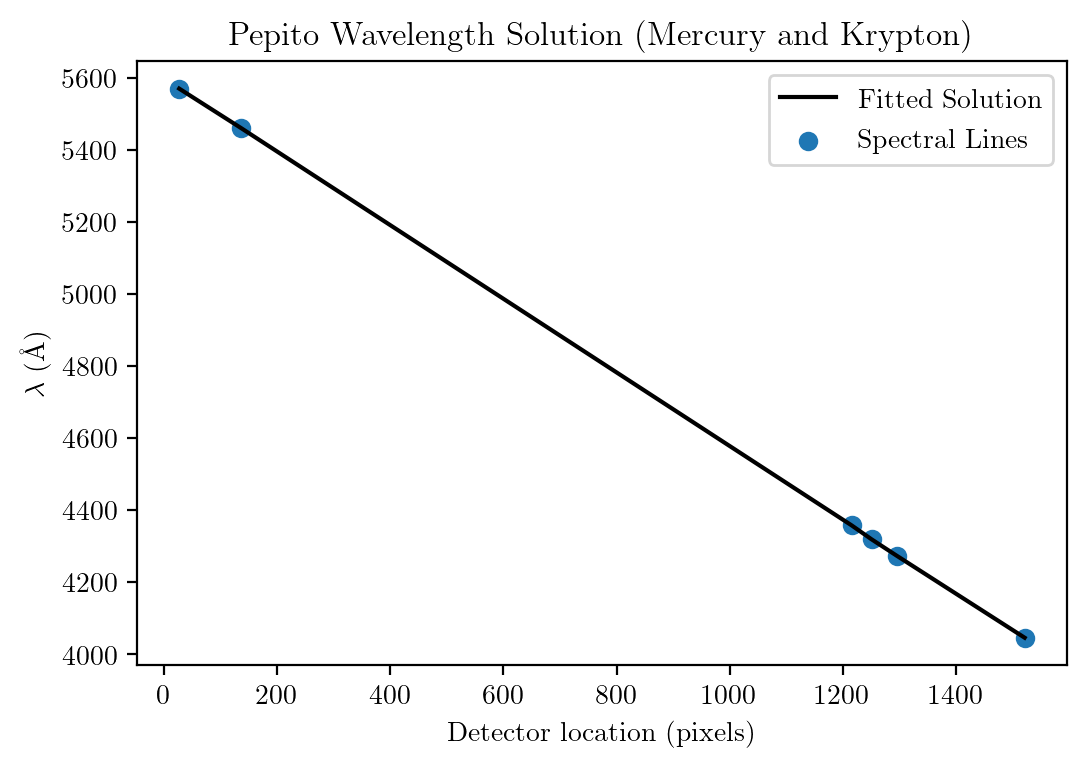

In [31]:
# Plot the fit
plt.figure(dpi = 100)
plt.rc('font', family='serif')
plt.scatter(hg_kr_locations, hg_kr_wavelengths, label='Spectral Lines')
plt.plot(hg_kr_locations, hg_kr_fitted_wavelengths, c='k', label='Fitted Solution')
plt.xlabel('Detector location (pixels)')
plt.ylabel(r'$\lambda$ (\AA)')
plt.title('Pepito Wavelength Solution (Mercury and Krypton)')
plt.legend()
plt.show()

In [32]:
hg_kr_residuals = hg_kr_fitted_wavelengths - hg_kr_wavelengths
print(np.std(hg_kr_residuals))

9.989789503219633e-12


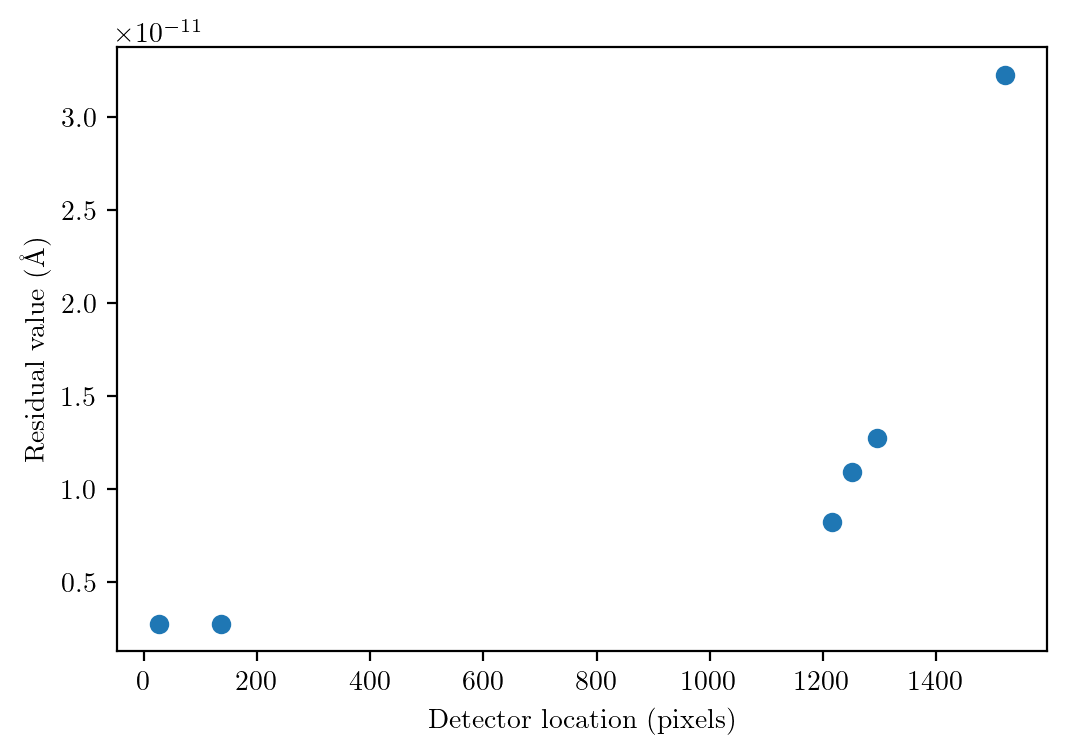

In [33]:
# Plot the residuals
plt.figure(dpi = 100)
plt.rc('font', family='serif')
plt.scatter(hg_kr_locations, hg_kr_residuals)
plt.xlabel('Detector location (pixels)')
plt.ylabel(r'Residual value (\AA)')
plt.show()

### Neon wavelength calibration

In [34]:
ne_im = imageio.imread('ne_lamp_1s_2.bmp')
ne_hdu = fits.PrimaryHDU(ne_im)
ne_hdu.writeto('Ne.fits', overwrite=True) 
ne_spec = fits.getdata('Ne.fits')

In [35]:
# Access the section of the image that has the spectrum on it
ne_rect = ne_spec[400:537,:] # Again, a little liberal, but want to get all of each line

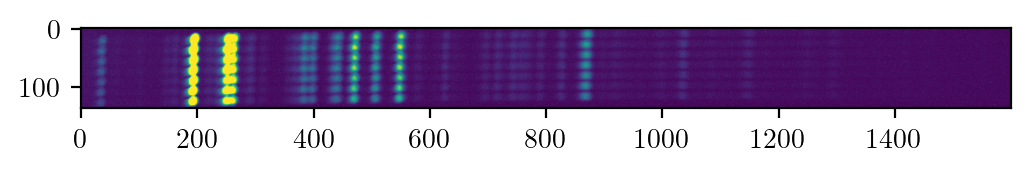

In [36]:
# Plot the spectrum
plt.figure(dpi = 100)
plt.rc('font', family='serif')
plt.imshow(ne_rect)

In [37]:
ne_collapsed = np.median(ne_rect, axis=0) # Collapse along the vertical (slit) axis
ne_detector_loc = np.arange(len(ne_collapsed)) # Create an array of pixel indices

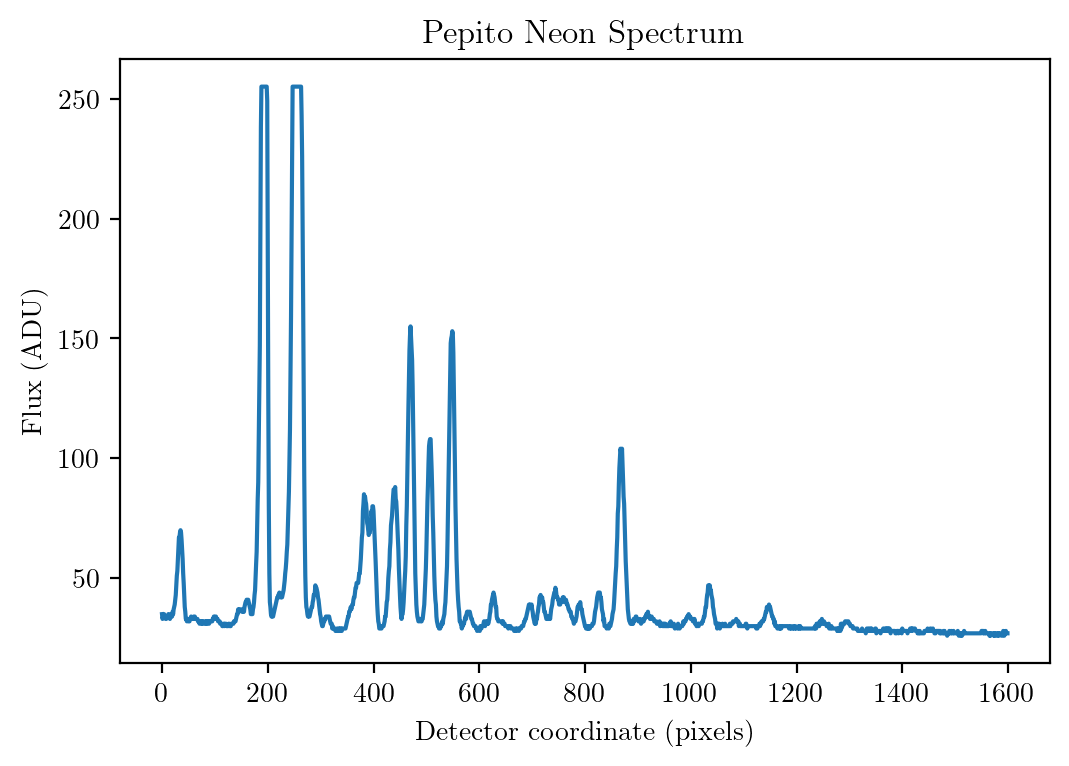

In [38]:
plt.figure(dpi = 100)
plt.rc('font', family='serif')
plt.plot(ne_detector_loc, ne_collapsed)
# plt.xlim([0, 1200]) # 1530 original lower bound
# plt.ylim([0, 5000])
plt.xlabel('Detector coordinate (pixels)')
plt.ylabel('Flux (ADU)')
plt.title('Pepito Neon Spectrum')
plt.show()

In [39]:
# Get centroid of line, using the plot above to guess bounds (NOT spectrum in DS9, that's harder)
print(f'{get_line_centroid([543, 552], ne_detector_loc, ne_collapsed):.2f}')

547.60


In [40]:
# Estimate wavelength of observed emission line in neon spectrum using our wavelength solution for mercury
print(f'{np.polyval(hg_kr_polynomial, 869.38):.2f}') 

4862.28


In [41]:
# Generate a CSV file that includes the detector location of the line as well as the wavelength you believe it is
# Use the centroiding function in the above cell instead of eye-ball estimates
# Get wavelength location of lines from: https://physics.nist.gov/PhysRefData/Handbook/Tables/neontable3_a.htm
# REMEMBER: 0 to 1600 pixels goes from red to blue
ne_line_data = np.genfromtxt('pepito_neon_lines.csv', names=True, delimiter=',', dtype=float)  # load our file
ne_wavelengths, ne_locations = ne_line_data['wl_AA'], ne_line_data['loc_px']
ne_argsort = np.argsort(ne_locations)  # sort the wavelengths by their detector locations to prevent issues later on
ne_locations, ne_wavelengths = ne_locations[ne_argsort], ne_wavelengths[ne_argsort]  # apply the sorted indices to the original arrays

In [42]:
print(ne_locations)
print(ne_wavelengths)

[ 33.67 194.44 261.7  547.6  869.38]
[5562.7662 5400.5618 5330.7775 5037.7512 4715.344 ]


In [43]:
ne_coeffs = np.polyfit(ne_locations, ne_wavelengths, deg=4)  # determine coefficients for a polynomial of degree 5 to be fit to the data
print(ne_coeffs)  # A*x^5 + B*x^4 + C*x^3 + D*x^2 + E*x + F; very small valued coefficients indicate you're probably over-fitting
ne_polynomial = np.poly1d(ne_coeffs)  # create a poly1d object from our coefficients for np.polyval to use
ne_fitted_wavelengths = np.polyval(ne_polynomial, ne_locations)  # get the wavelength from the fit for the specified detector coordinates

[-3.71449169e-10  6.98909173e-07 -4.03281884e-04 -9.45421492e-01
  5.59502953e+03]


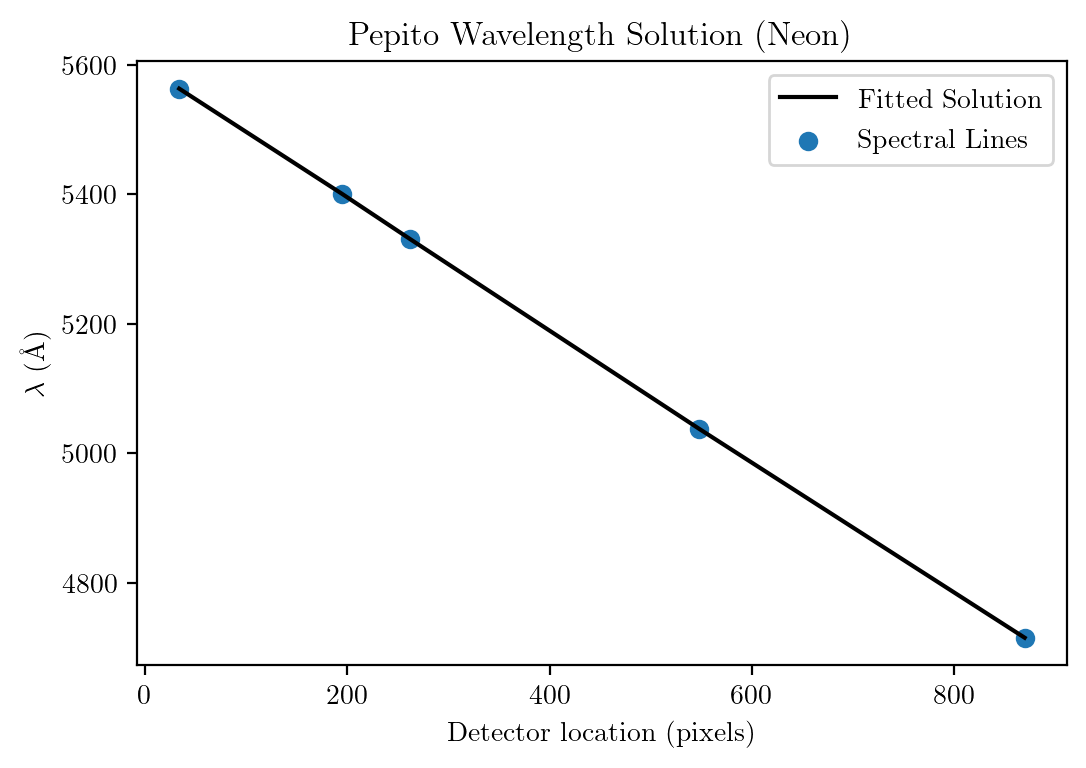

In [44]:
# Plot the fit
plt.figure(dpi = 100)
plt.rc('font', family='serif')
plt.scatter(ne_locations, ne_wavelengths, label='Spectral Lines')
plt.plot(ne_locations, ne_fitted_wavelengths, c='k', label='Fitted Solution')
plt.xlabel('Detector location (pixels)')
plt.ylabel(r'$\lambda$ (\AA)')
plt.title('Pepito Wavelength Solution (Neon)')
plt.legend()
plt.show()

In [45]:
ne_residuals = ne_fitted_wavelengths - ne_wavelengths
print(np.std(ne_residuals))

3.637978807091713e-13


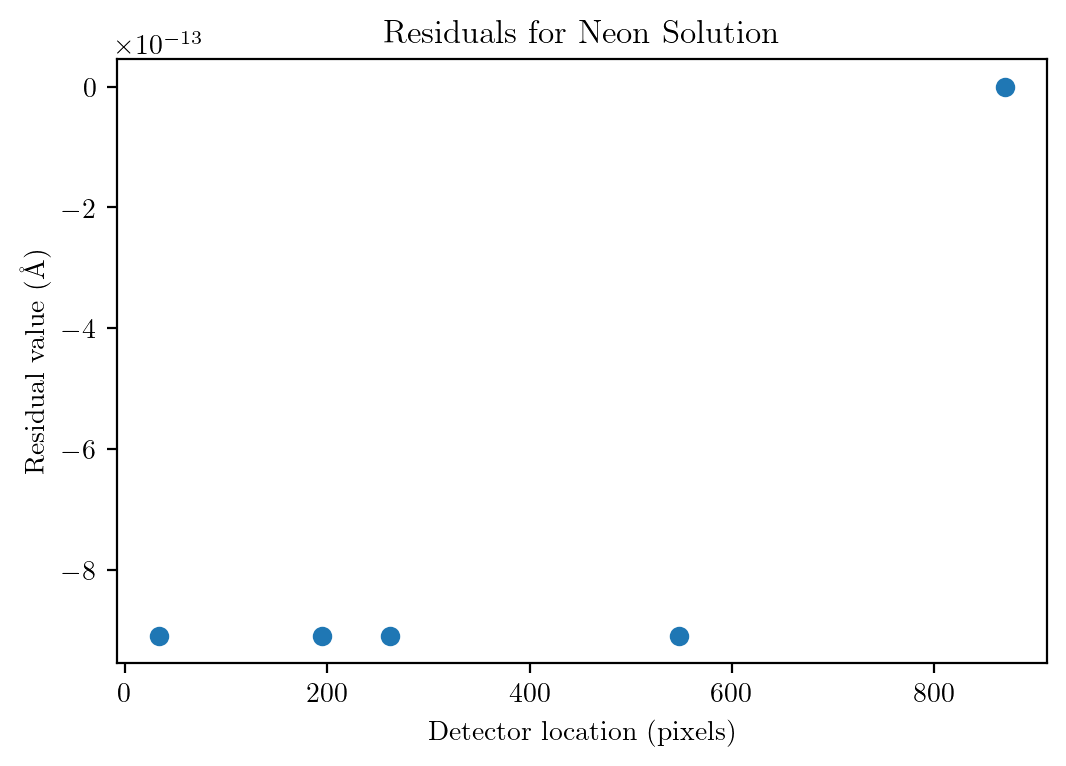

In [46]:
# Plot the residuals
plt.figure(dpi = 100)
plt.rc('font', family='serif')
plt.scatter(ne_locations, ne_residuals)
plt.xlabel('Detector location (pixels)')
plt.ylabel(r'Residual value (\AA)')
plt.title('Residuals for Neon Solution')
plt.show()

### Neon intensity versus wavelength (identifying known lines)

In [47]:
ne_wavelength = np.polyval(ne_polynomial, ne_detector_loc)
print(ne_wavelength)

[5595.02952936 5594.08370528 5593.13707883 ... 3487.19385141 3484.25346518
 3481.30759111]


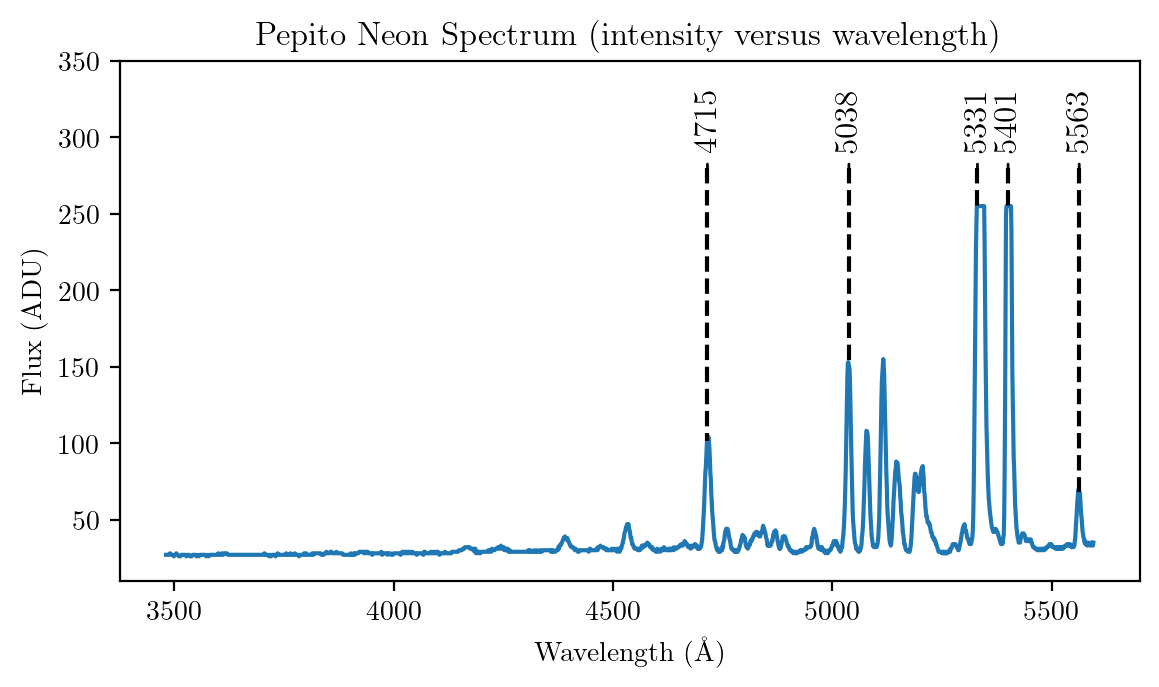

In [48]:
import lineid_plot
plt.rc('font', family='serif')
line_wave = [5562.7662, 5400.5618, 5330.7775, 5037.7512, 4715.344]
line_label1 = ['5563', '5401', '5331', '5038', '4715']
fig, ax = lineid_plot.plot_line_ids(ne_wavelength, ne_collapsed, line_wave, line_label1, arrow_tip = 280, box_axes_space=0.08)
fig.set_dpi(100)
plt.ylim(10,350)
plt.xlabel(r'Wavelength (\AA)')
plt.ylabel('Flux (ADU)')
plt.title('Pepito Neon Spectrum (intensity versus wavelength)')
plt.show()

### All lines

In [67]:
all_line_data = np.genfromtxt('pepito_all_lines.csv', names=True, delimiter=',', dtype=float)  # load our file
all_wavelengths, all_locations, all_lamps = all_line_data['wl_AA'], all_line_data['loc_px'], all_line_data['lamp']
all_argsort = np.argsort(all_locations)  # sort the wavelengths by their detector locations to prevent issues later on
all_locations, all_wavelengths = all_locations[all_argsort], all_wavelengths[all_argsort]  # apply the sorted indices to the original arrays

In [74]:
print(all_locations)
print(all_wavelengths)

[  27.46   33.67  136.85  194.44  261.7   547.6   869.38 1215.22 1250.49
 1295.03 1520.87]
[5570.2894 5562.7662 5460.735  5400.5618 5330.7775 5037.7512 4715.344
 4358.328  4319.5794 4273.9694 4046.563 ]


In [69]:
all_coeffs = np.polyfit(all_locations, all_wavelengths, deg=4)  # determine coefficients for a polynomial of degree 5 to be fit to the data
print(all_coeffs)  # A*x^5 + B*x^4 + C*x^3 + D*x^2 + E*x + F; very small valued coefficients indicate you're probably over-fitting
all_polynomial = np.poly1d(all_coeffs)  # create a poly1d object from our coefficients for np.polyval to use
all_fitted_wavelengths = np.polyval(all_polynomial, all_locations)  # get the wavelength from the fit for the specified detector coordinates

[ 2.21410276e-11 -6.56048983e-08  5.72799452e-05 -1.03437110e+00
  5.59897323e+03]


In [82]:
# Get lamp for each line, since np.genfromtxt won't do this
import pandas as pd
df = pd.read_csv('pepito_all_lines.csv')
all_lamps = np.array(df["lamp"])
print(all_lamps)

['Ne' 'Ne' 'Ne' 'Ne' 'Ne' 'Kr' 'Kr' 'Kr' 'Hg' 'Hg' 'Hg']


<IPython.core.display.Javascript object>


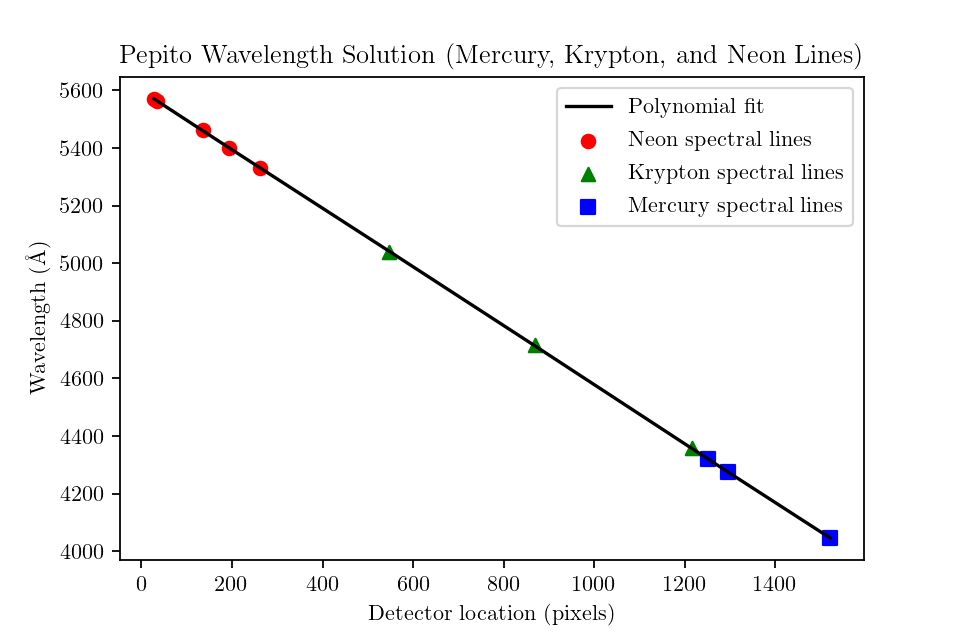

In [100]:
# Plot the fit
plt.figure(dpi = 100)
plt.rc('font', family='serif')
plt.scatter(all_locations[:5], all_wavelengths[:5], c='r',label='Neon spectral lines')
plt.scatter(all_locations[5:8], all_wavelengths[5:8], c='g', marker='^', label='Krypton spectral lines')
plt.scatter(all_locations[8:], all_wavelengths[8:], c='b', marker='s', label='Mercury spectral lines')
plt.plot(all_locations, all_fitted_wavelengths, c='k', label='Polynomial fit')
plt.xlabel('Detector location (pixels)')
plt.ylabel(r'Wavelength (\AA)')
plt.title('Pepito Wavelength Solution (Mercury, Krypton, and Neon Lines)')
plt.legend()
plt.savefig("wavelength_solution.png", dpi=250, facecolor='w', edgecolor='w')
plt.show()

In [103]:
all_residuals = all_fitted_wavelengths - all_wavelengths
print(np.mean(all_residuals))
print(np.std(all_residuals))

4.134066826240583e-13
1.7172298116619118


<IPython.core.display.Javascript object>


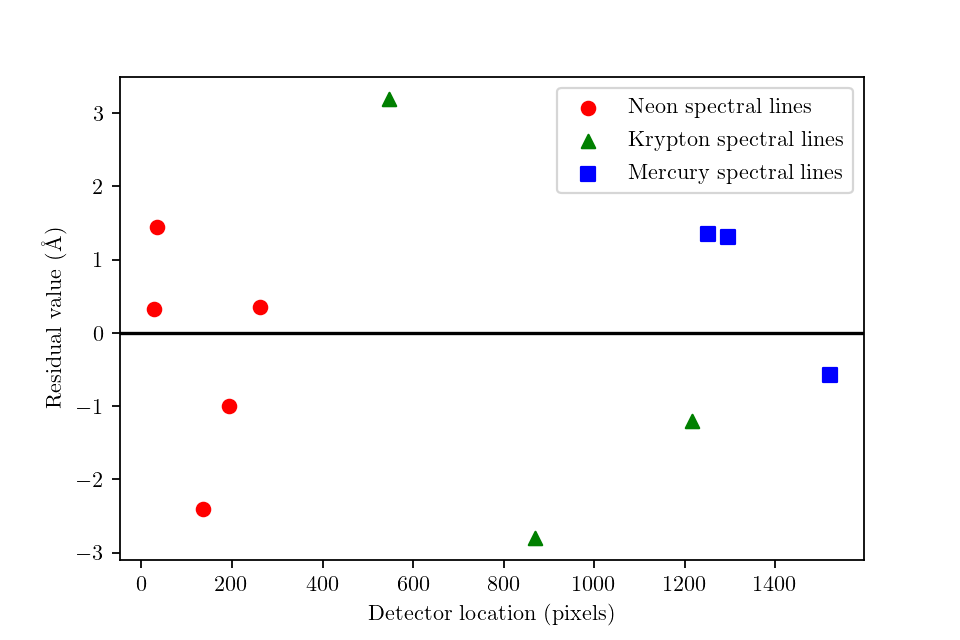

In [104]:
# Plot the residuals
plt.figure(dpi = 100)
plt.rc('font', family='serif')
# plt.scatter(all_locations, all_residuals)
plt.scatter(all_locations[:5], all_residuals[:5], c='r',label='Neon spectral lines')
plt.scatter(all_locations[5:8], all_residuals[5:8], c='g', marker='^', label='Krypton spectral lines')
plt.scatter(all_locations[8:], all_residuals[8:], c='b', marker='s', label='Mercury spectral lines')
plt.axhline(np.mean(all_residuals), c='k')
plt.xlabel('Detector location (pixels)')
plt.ylabel(r'Residual value (\AA)')
plt.legend()
plt.savefig("wavelength_solution_resid.png", dpi=250, facecolor='w', edgecolor='w')
plt.show()